In [1]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import glob
import os
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
import split_valid

Using TensorFlow backend.


使用InceptionV3模型

In [2]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [3]:
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
test_dir = "data/imgs/test1"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)

分割验证集

In [4]:
drivers_pd = pd.read_csv("data/drivers_img_nop081_list.csv")
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
choices = ["p024", "p002"]

In [5]:
split_valid.split(choice_ids=choices, 
                  train_pd_path="data/drivers_img_nop081_list.csv", 
                  train_aug_pd_path="data/drivers_img_aug_list.csv", 
                  train_dir=train_dir, 
                  val_dir=val_dir, 
                  test_dir=test_dir, 
                  origin_test_dir="data/imgs/test", 
                  saved_weights_dir="saved_weights")

选择作为验证集的司机ID: ['p024', 'p002']
分割的训练集数量: 20373 ，验证集数量: 1951
从增强数据集中分割的训练集数量: 20373
link images to directory data/imgs/train2
link augmented images to directory data/imgs/train2
link images to directory data/imgs/val2
split valid data done!


In [6]:
def get_im_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

图片预处理

In [4]:
# 图像生成器输出的图像大小
out_image_size = (299, 299)
batch_size = 96

In [8]:
# 训练集图像生成器
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1./255
)

# 验证集图像生成器
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 40746 images belonging to 10 classes.
Found 1951 images belonging to 10 classes.


构建模型

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax', use_bias=False, kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions, name=base_model.name)

op = Adam(lr=0.00005, decay=2e-8)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

开始训练

In [14]:
# 训练代数
epochs = 20

save_file = saved_weights + '/' + model.name + '_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
callbacks = [
    ModelCheckpoint(save_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1, period=1),
    EarlyStopping(monitor="val_loss", verbose=1, mode="min", min_delta=0.0005, patience=3)
]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

model name: inception_v3 , will save weight file: saved_weights/inception_v3_model.h5
Epoch 1/20
425/425 [==============================] - 1101s 3s/step - loss: 0.5540 - acc: 0.8888 - val_loss: 0.2646 - val_acc: 0.9769

Epoch 00001: val_loss improved from inf to 0.26456, saving model to saved_weights/inception_v3_model.h5
Epoch 2/20
425/425 [==============================] - 1030s 2s/step - loss: 0.1946 - acc: 0.9944 - val_loss: 0.2528 - val_acc: 0.9708

Epoch 00002: val_loss improved from 0.26456 to 0.25283, saving model to saved_weights/inception_v3_model.h5
Epoch 3/20
425/425 [==============================] - 1038s 2s/step - loss: 0.1534 - acc: 0.9974 - val_loss: 0.2762 - val_acc: 0.9431

Epoch 00003: val_loss did not improve from 0.25283
Epoch 4/20
425/425 [==============================] - 1027s 2s/step - loss: 0.1187 - acc: 0.9981 - val_loss: 0.1847 - val_acc: 0.9646

Epoch 00004: val_loss improved from 0.25283 to 0.18466, saving model to saved_weights/inception_v3_model.h5
Epo

绘制图型

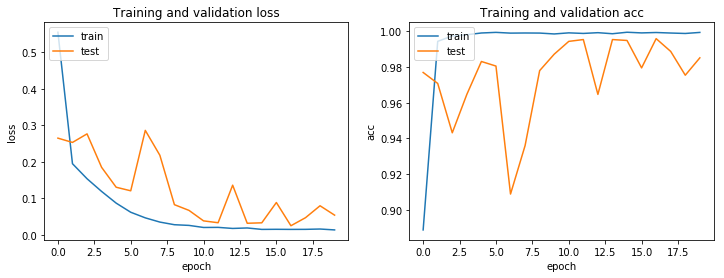

In [16]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

测试预测结果

In [5]:
from keras.models import load_model

pred_model = load_model("saved_weights/inception_v3_model.h5")

预测所有测试集，并生成提交kaggle的报告

In [86]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
pred_batch_size=128

test_generator = test_datagen.flow_from_directory(test_dir, out_image_size, shuffle=False, 
                                             batch_size=pred_batch_size, class_mode=None)

test_generator.filenames[0]

Found 79726 images belonging to 1 classes.


'test/img_1.jpg'

In [12]:
sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = pred_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/pred_inception_v3.csv', index=None)
print("predict done.")

623/623 [==============================] - 1580s 3s/step
y_pred shape (79726, 10)
              img     c0     c1     c2     c3     c4     c5     c6     c7  \
0       img_1.jpg  0.005  0.005  0.005  0.005  0.005  0.995  0.005  0.005   
1      img_10.jpg  0.005  0.005  0.005  0.005  0.005  0.995  0.005  0.005   
2     img_100.jpg  0.995  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
3    img_1000.jpg  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
4  img_100000.jpg  0.005  0.005  0.005  0.995  0.005  0.005  0.005  0.005   

      c8     c9  
0  0.005  0.005  
1  0.005  0.005  
2  0.005  0.005  
3  0.995  0.005  
4  0.005  0.005  
predict done.


Found 79726 images belonging to 1 classes.


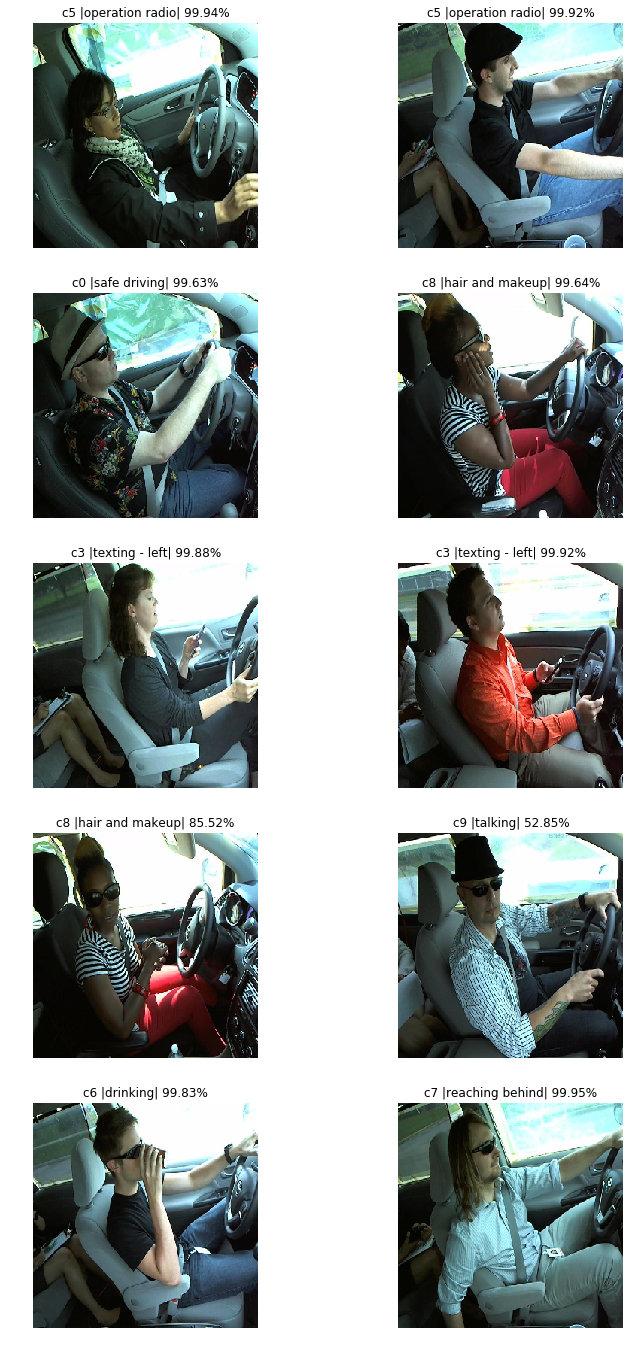

In [6]:
from pred_view import view_pred

view_pred(pred_model, show_num=10, test_dir=test_dir, out_image_size=out_image_size, preprocess_input=preprocess_input)


提交到kaggle中后得到成绩：private: 0.28068, public: 0.31967